In [1]:
# Libraries
import os
import numpy as np
import keras
import tensorflow as tf
from importlib import reload

# Scripts
from acml import data, runners, utils

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [4]:
reload(data)

<module 'acml.data' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\data.py'>

In [5]:
reload(runners)

<module 'acml.runners' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\runners.py'>

In [6]:
reload(utils)

<module 'acml.utils' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\utils.py'>

## `main`

In [3]:
# Silence information messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 

GPU DETECTED ✓


### Load data

In [4]:
import pandas as pd
from tqdm import tqdm

path = 'data/csv_qiandao_npz/kaiyuan'
sub_folders = ['target', 'other']
npz = True

data_1D = []

for folder in sub_folders:
    subfolder_path = os.path.join(path, folder)
    for datafile in tqdm(os.listdir(subfolder_path)):
        datafile_path = os.path.join(subfolder_path, datafile)
        if npz:
            data_1D.append(np.load(datafile_path)['np_data'])
        else:
            data_1D.append(pd.read_csv(datafile_path, header=None).values)

  0%|          | 0/1947 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:49<00:00, 81.34it/s] 


In [5]:
specs = np.stack(data_1D)
specs = np.expand_dims(specs, axis=-1)
print(specs.shape)

(5947, 307, 512, 1)


In [6]:
# Resize spectrograms to be square
specs = np.resize(specs, (5947, 128, 128, 1))

### Initialise model

In [8]:
from models import irfan_2020_modified 
reload(irfan_2020_modified)

irfan = irfan_2020_modified.get_compiled_model_128()
print(irfan.summary())

Model: "irfan_2020"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        3

### Configure and fit model

In [9]:
# with tf.device('/CPU:0'):
history = irfan.fit(
    x=specs,
    y=specs,
    batch_size=16,
    epochs=20,
    verbose=2
)

Epoch 1/20
372/372 - 24s - loss: 24.4388 - accuracy: 0.0000e+00 - 24s/epoch - 64ms/step
Epoch 2/20
372/372 - 14s - loss: 17.0931 - accuracy: 0.0000e+00 - 14s/epoch - 38ms/step
Epoch 3/20
372/372 - 15s - loss: 13.6607 - accuracy: 0.0000e+00 - 15s/epoch - 40ms/step
Epoch 4/20
372/372 - 15s - loss: 11.0598 - accuracy: 0.0000e+00 - 15s/epoch - 42ms/step
Epoch 5/20
372/372 - 15s - loss: 9.0912 - accuracy: 1.0263e-08 - 15s/epoch - 41ms/step
Epoch 6/20
372/372 - 15s - loss: 7.4947 - accuracy: 2.0526e-08 - 15s/epoch - 40ms/step
Epoch 7/20
372/372 - 15s - loss: 6.2839 - accuracy: 2.0526e-08 - 15s/epoch - 40ms/step
Epoch 8/20
372/372 - 15s - loss: 5.3481 - accuracy: 2.0526e-08 - 15s/epoch - 40ms/step
Epoch 9/20
372/372 - 15s - loss: 4.5928 - accuracy: 1.0263e-08 - 15s/epoch - 41ms/step
Epoch 10/20
372/372 - 16s - loss: 4.0318 - accuracy: 2.0526e-08 - 16s/epoch - 42ms/step
Epoch 11/20
372/372 - 15s - loss: 3.6585 - accuracy: 2.0526e-08 - 15s/epoch - 42ms/step
Epoch 12/20
372/372 - 16s - loss: 3.3

In [10]:
keras.models.save_model(irfan, 'models\keras\irfan_pretrain.keras')

### Calculate metrics

C:\Users\sonar\AppData\Local\Temp\ipykernel_27612\3924299184.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


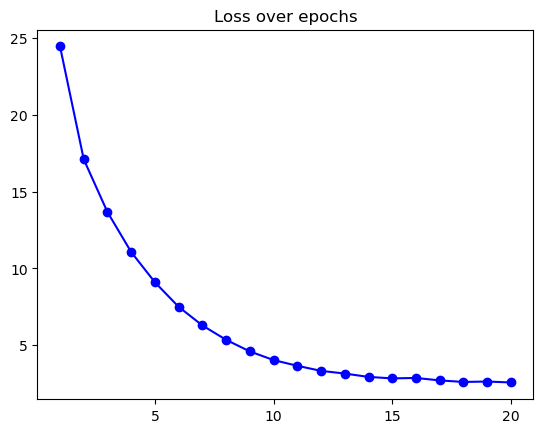

In [11]:
reload(utils)

fig = utils.get_loss_curve(history)
fig.show()